In [10]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from PIL import Image
import autoencoders
from torch.utils.data import TensorDataset, DataLoader

def draw_circle(radius, center_x=0.5, center_y=0.5, size=28):
    # draw a circle using coordinates for the center, and the radius
    circle = plt.Circle((center_x, center_y), radius, color='k', fill=False)
    fig, ax = plt.subplots(figsize=(1, 1))
    ax.add_patch(circle)
    ax.axis('off')
    buf = fig.canvas.print_to_buffer()
    plt.close()
    # converts matplotlib figure into PIL image, make it grayscale, and resize it
    return np.array(Image.frombuffer('RGBA', buf[1], buf[0]).convert('L').resize((int(size), int(size))))

def gen_circles(n, size=28):
    # generates random coordinates around (0.5, 0.5) as center points
    center_x = np.random.uniform(0.0, 0.03, size=n).reshape(-1, 1)+.5
    center_y = np.random.uniform(0.0, 0.03, size=n).reshape(-1, 1)+.5
    # generates random radius sizes between 0.03 and 0.47
    radius = np.random.uniform(0.03, 0.47, size=n).reshape(-1, 1)
    sizes = np.ones((n, 1))*size

    coords = np.concatenate([radius, center_x, center_y, sizes], axis=1)
    # generates circles using draw_circle function
    circles = np.apply_along_axis(func1d=lambda v: draw_circle(*v), axis=1, arr=coords)
    return circles, radius

np.random.seed(42)
# generates 1,000 circles
circles, radius = gen_circles(1000)

circles_ds = TensorDataset(torch.as_tensor(circles).unsqueeze(1).float()/255, torch.as_tensor(radius))
circles_dl = DataLoader(circles_ds, batch_size=32, shuffle=True, drop_last=True)

/home/DKS0559531/miniconda3/envs/torch/lib/python3.10/site-packages/torchvision/io/image.py:11: UserWarning: Failed to load image Python extension: /home/DKS0559531/miniconda3/envs/torch/lib/python3.10/site-packages/torchvision/image.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKNSt7__cxx1112basic_stringIcSt11char_traitsIcESaIcEEE
  warn(f"Failed to load image Python extension: {e}")


In [11]:
import torch.nn as nn

def set_seed(self, seed=42):
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.manual_seed(seed)
    np.random.seed(seed)

class Encoder(nn.Module):
    def __init__(self, input_shape, z_size, base_model):
        super().__init__()
        self.input_shape = input_shape
        self.z_size = z_size
        self.base_model = base_model
        
        # appends the "lin_latent" linear layer to map from "output_size" 
        # given by the base model to desired size of the representation (z_size)
        output_size = self._get_output_size()
        self.lin_latent = nn.Linear(output_size, z_size)
        
    def _get_output_size(self):
        # builds a dummy batch containing one dummy tensor
        # full of zeroes with the same shape as the inputs
        device = next(self.base_model.parameters()).device.type
        dummy = torch.zeros(1, *self.input_shape, device=device)
        # sends the dummy batch through the base model to get 
        # the output size produced by it
        size = self.base_model(dummy).size(1)
        return size
        
    def forward(self, x):
        # forwards the input through the base model and then the "lin_latent" layer 
        # to get the representation (z)
        base_out = self.base_model(x)
        out = self.lin_latent(base_out)        
        return out

set_seed(13)

# we defined our representation (z) as a vector of size one
z_size = 1
# our images are 1@28x28
input_shape = (1, 28, 28) # (C, H, W)

base_model = nn.Sequential(
    # (C, H, W) -> C*H*W
    nn.Flatten(),
    # C*H*W -> 2048
    nn.Linear(np.prod(input_shape), 2048),
    nn.LeakyReLU(),
    # 2048 -> 2048
    nn.Linear(2048, 2048),
    nn.LeakyReLU(),
)

encoder = Encoder(input_shape, z_size, base_model)

In [12]:
decoder = nn.Sequential(
    # z_size -> 2048
    nn.Linear(z_size, 2048),
    nn.LeakyReLU(),
    # 2048 -> 2048
    nn.Linear(2048, 2048),
    nn.LeakyReLU(),
    # 2048 -> C*H*W
    nn.Linear(2048, np.prod(input_shape)),
    # C*H*W -> (C, H, W)
    nn.Unflatten(1, input_shape)
)

In [13]:
x, _ = circles_ds[7]
z = encoder(x)
z

tensor([[-0.1209]], grad_fn=<AddmmBackward0>)

In [14]:
x_tilde = decoder(z)
x_tilde, x_tilde.shape

(tensor([[[[ 1.9079e-01, -4.3900e-02, -4.9170e-02,  5.2142e-02, -8.0119e-02,
            -1.6324e-01,  3.8319e-02,  6.2965e-02, -3.7442e-02, -3.6085e-02,
             2.2930e-02, -1.2089e-01,  2.0558e-01,  1.3671e-01,  1.4608e-03,
             1.1066e-02, -1.3429e-01, -3.7842e-02,  6.1736e-02, -3.0216e-02,
            -7.4171e-02, -1.6376e-02, -6.4663e-02, -1.5638e-01, -9.6260e-02,
             5.3312e-02,  6.6354e-02, -2.6916e-02],
           [ 1.8874e-01,  9.7503e-02, -1.3948e-01, -1.2955e-01, -1.2210e-02,
             5.6815e-02, -7.5753e-02,  5.3483e-02,  6.4153e-02, -1.6740e-01,
            -5.0190e-02,  6.2855e-02,  9.7707e-02, -2.2777e-02, -1.1442e-01,
             1.6079e-01, -1.4634e-01,  2.0068e-01, -2.7668e-02,  6.3487e-02,
            -9.6758e-02,  3.0803e-02, -7.0600e-02,  1.1162e-01,  8.6569e-02,
            -1.5205e-02,  1.9754e-01,  1.1691e-01],
           [-7.3312e-02,  9.0082e-02, -4.4267e-02,  1.1471e-01,  6.9005e-02,
             1.5235e-03, -4.2527e-02,  1.4255e-01

In [15]:
class AutoEncoder(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.enc = encoder
        self.dec = decoder
        
    def forward(self, x):
        # when encoder met decoder
        enc_out = self.enc(x)
        return self.dec(enc_out)
    
model_ae = AutoEncoder(encoder, decoder)

In [16]:
set_seed(13)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model_ae.to(device)
loss_fn = nn.MSELoss()
optim = torch.optim.Adam(model_ae.parameters(), 0.0003)

num_epochs = 10

train_losses = []

for epoch in range(1, num_epochs+1):
    batch_losses = []
    for i, (x, _) in enumerate(circles_dl):
        model_ae.train()
        x = x.to(device)

        # Step 1 - Computes our model's predicted output - forward pass
        yhat = model_ae(x)
        # Step 2 - Computes the loss
        loss = loss_fn(yhat, x) 
        # Step 3 - Computes gradients
        loss.backward()
        # Step 4 - Updates parameters using gradients and the learning rate
        optim.step()
        optim.zero_grad()
        
        batch_losses.append(np.array([loss.data.item()]))

    # Average over batches
    train_losses.append(np.array(batch_losses).mean(axis=0))

    print(f'Epoch {epoch:03d} | Loss >> {train_losses[-1][0]:.4f}')

Epoch 001 | Loss >> 0.1388
Epoch 002 | Loss >> 0.0062
Epoch 003 | Loss >> 0.0049
Epoch 004 | Loss >> 0.0048
Epoch 005 | Loss >> 0.0048
Epoch 006 | Loss >> 0.0048
Epoch 007 | Loss >> 0.0048
Epoch 008 | Loss >> 0.0048
Epoch 009 | Loss >> 0.0047
Epoch 010 | Loss >> 0.0045


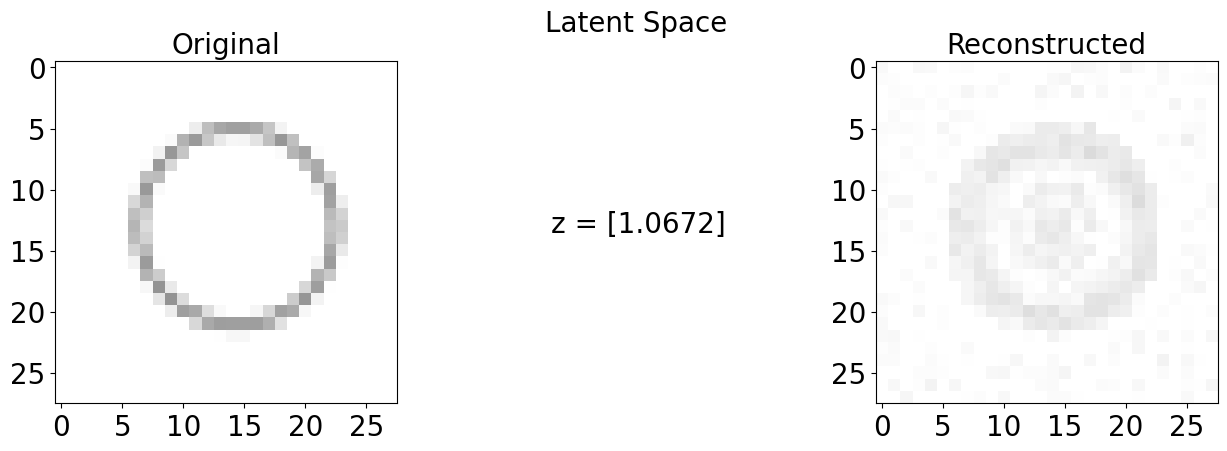

In [17]:
fig = autoencoders.figure2(model_ae, circles_ds[7][0], device)

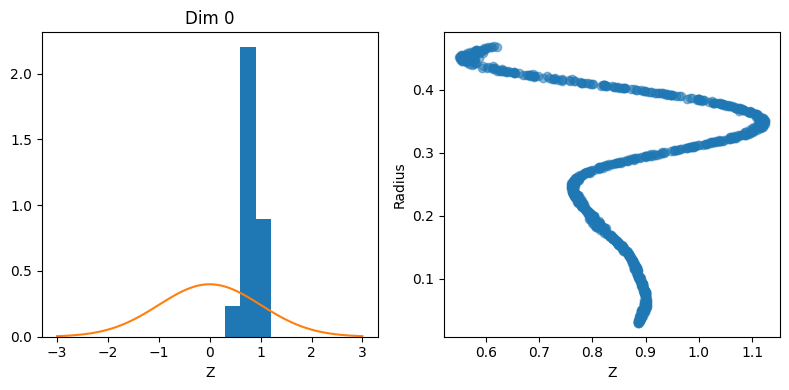

In [18]:
aeviz1 = autoencoders.AEViz(model_ae.enc, model_ae.dec, circles_dl)
fig, axs = plt.subplots(1, 2, figsize=(8, 4))
_ = aeviz1.plot_latent(ax=axs[1])
_ = aeviz1.plot_z_dist(n_cols=1, bins=np.linspace(-3, 3, 21), axs=axs[0])

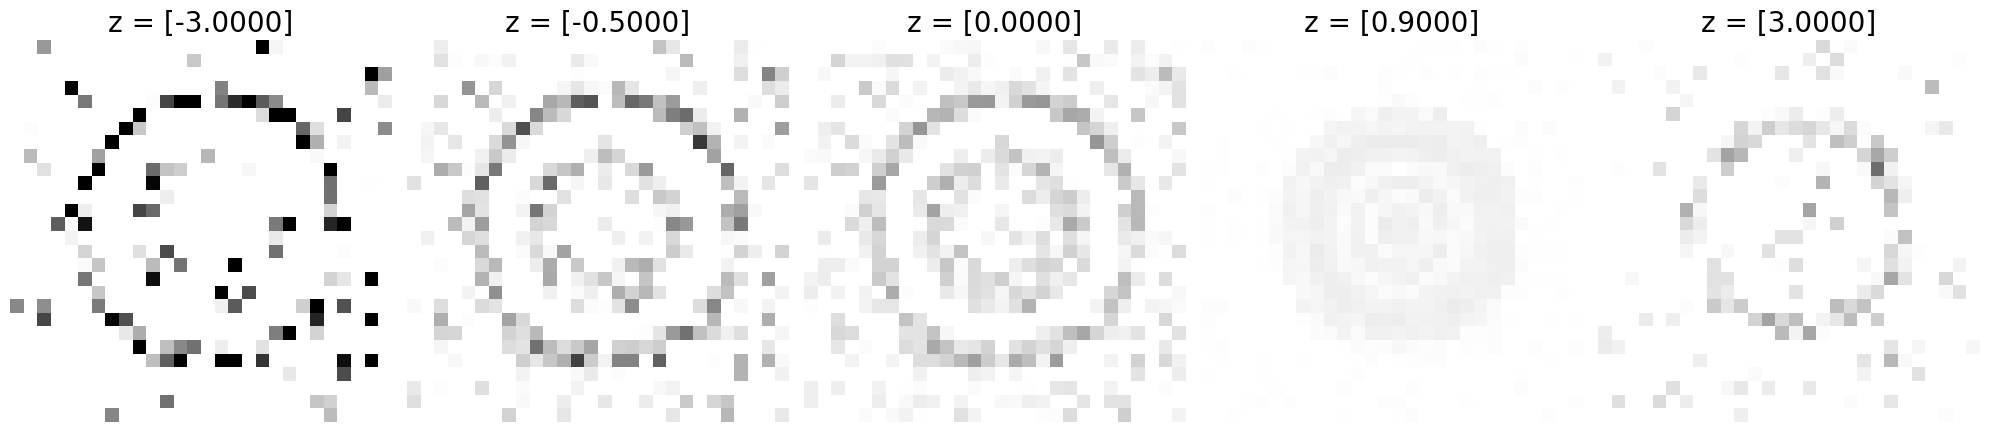

In [19]:
fig = autoencoders.figure4(model_ae, device)